# Convolutional Neural Networks
---
In this notebook, we train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<img src='notebook_ims/cifar_data.png' width=70% height=70% />

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [1]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


---
## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

  0%|          | 0/170498071 [00:00<?, ?it/s]

100%|█████████▉| 170401792/170498071 [01:37<00:00, 1158419.08it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### Visualize a Batch of Training Data

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

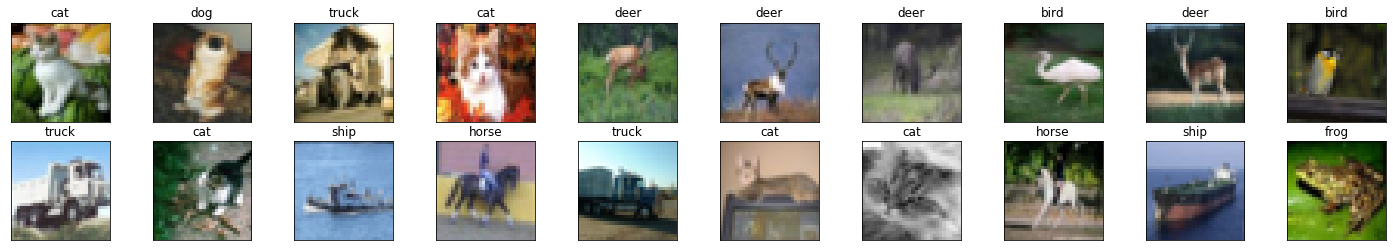

In [4]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

170500096it [01:50, 1158419.08it/s]                               

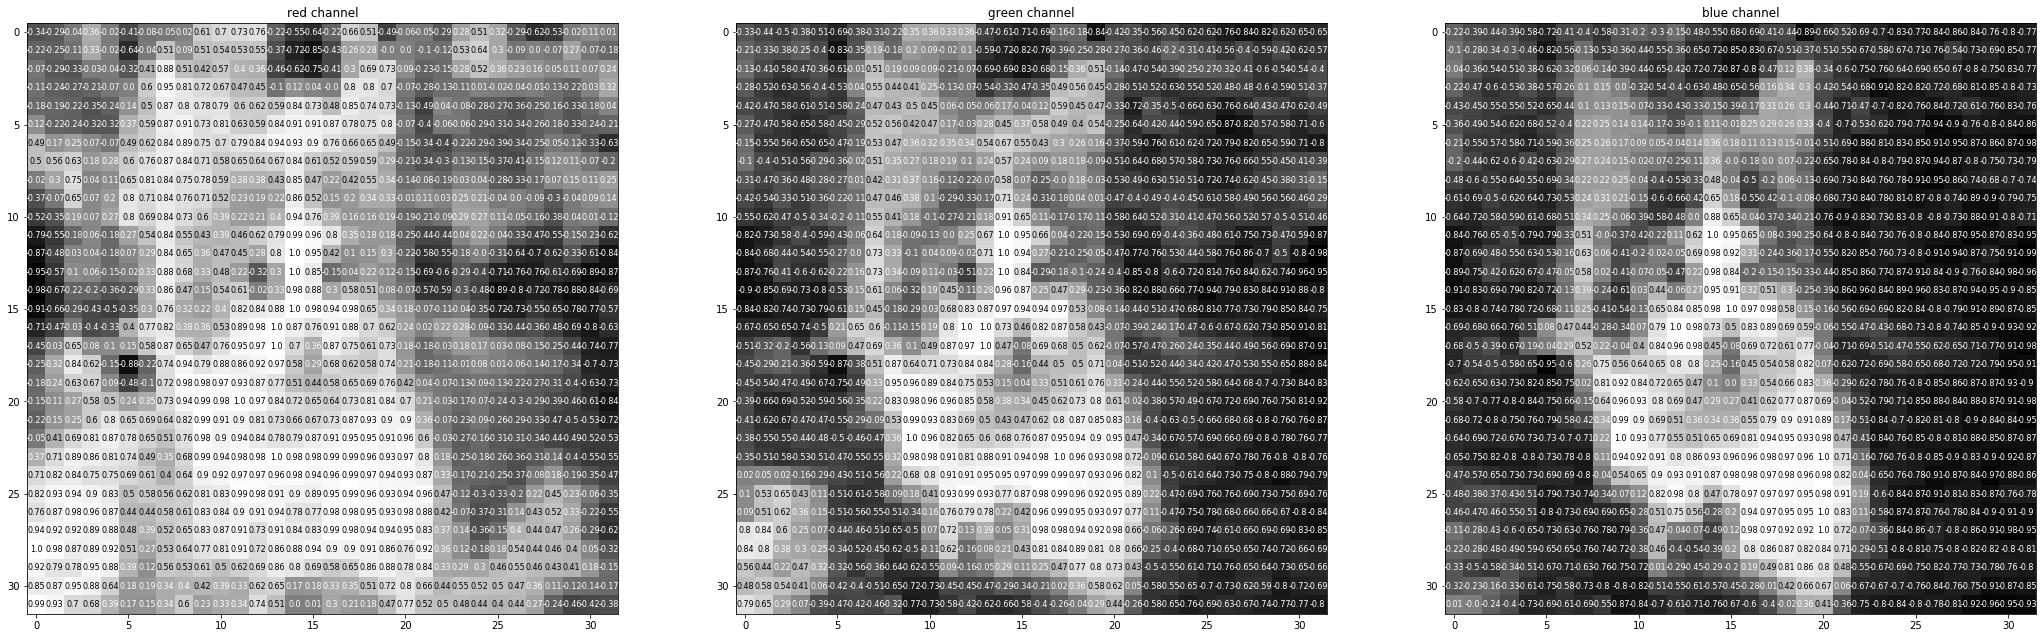

In [5]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

This time, you'll define a CNN architecture. Instead of an MLP, which used linear, fully-connected layers, you'll use the following:
* [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), which can be thought of as stack of filtered images.
* [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), which reduce the x-y size of an input, keeping only the most _active_ pixels from the previous layer.
* The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.

A network with 2 convolutional layers is shown in the image below and in the code, and you've been given starter code with one convolutional and one maxpooling layer.

<img src='notebook_ims/2_layer_conv.png' height=50% width=50% />

#### TODO: Define a model with multiple convolutional layers, and define the feedforward network behavior.

The more convolutional layers you include, the more complex patterns in color and shape a model can detect. It's suggested that your final model include 2 or 3 convolutional layers as well as linear layers + dropout in between to avoid overfitting. 

It's good practice to look at existing research and implementations of related models as a starting point for defining your own models. You may find it useful to look at [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) to help decide on a final structure.

#### Output volume for a convolutional layer

To compute the output size of a given convolutional layer we can perform the following calculation (taken from [Stanford's cs231n course](http://cs231n.github.io/convolutional-networks/#layers)):
> We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by `(W−F+2P)/S+1`. 

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.

In [23]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py). Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.

#### TODO: Define the loss and optimizer and see how these choices change the loss over time.

In [24]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


---
## Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

In [25]:
# number of epochs to train the model
n_epochs = 8 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.750718 	Validation Loss: 0.387314
Validation loss decreased (inf --> 0.387314).  Saving model ...
Epoch: 2 	Training Loss: 1.420526 	Validation Loss: 0.322392
Validation loss decreased (0.387314 --> 0.322392).  Saving model ...
Epoch: 3 	Training Loss: 1.248619 	Validation Loss: 0.301956
Validation loss decreased (0.322392 --> 0.301956).  Saving model ...
Epoch: 4 	Training Loss: 1.155978 	Validation Loss: 0.277622
Validation loss decreased (0.301956 --> 0.277622).  Saving model ...
Epoch: 5 	Training Loss: 1.083364 	Validation Loss: 0.267485
Validation loss decreased (0.277622 --> 0.267485).  Saving model ...
Epoch: 6 	Training Loss: 1.015767 	Validation Loss: 0.252895
Validation loss decreased (0.267485 --> 0.252895).  Saving model ...
Epoch: 7 	Training Loss: 0.961660 	Validation Loss: 0.240561
Validation loss decreased (0.252895 --> 0.240561).  Saving model ...
Epoch: 8 	Training Loss: 0.913473 	Validation Loss: 0.232573
Validation loss decreased (0.24056

###  Load the Model with the Lowest Validation Loss

In [26]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

---
## Test the Trained Network

Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

In [27]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.159598

Test Accuracy of airplane: 61% (618/1000)
Test Accuracy of automobile: 77% (771/1000)
Test Accuracy of  bird: 48% (488/1000)
Test Accuracy of   cat: 31% (312/1000)
Test Accuracy of  deer: 36% (367/1000)
Test Accuracy of   dog: 53% (533/1000)
Test Accuracy of  frog: 67% (674/1000)
Test Accuracy of horse: 75% (755/1000)
Test Accuracy of  ship: 70% (709/1000)
Test Accuracy of truck: 70% (700/1000)

Test Accuracy (Overall): 59% (5927/10000)


### Question: What are your model's weaknesses and how might they be improved?

**Answer**: (double-click to edit and add an answer)

### Visualize Sample Test Results

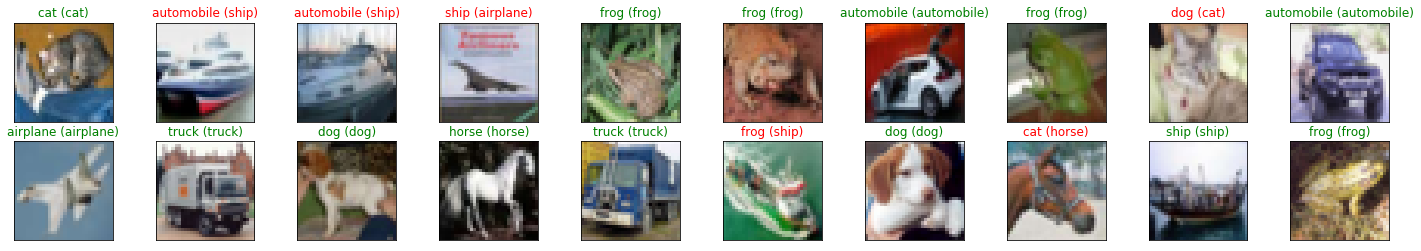

In [28]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))